# Convolutional Autoencoder

![](https://cdn-images-1.medium.com/max/800/1*LSYNW5m3TN7xRX61BZhoZA.png)

In this example we will demonstrate how you can create a convolutional autoencoder in Gluon

In [1]:
import random

import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import autograd, gluon

## Data

We will use the FashionMNIST dataset, which is of a similar format to MNIST but is richer and has more variance

In [3]:
batch_size = 512
ctx = mx.gpu() if len(mx.test_utils.list_gpus()) > 0 else mx.cpu()

In [4]:
transform = lambda x,y: (x.transpose((2,0,1)).astype('float32')/255., y)

train_dataset = gluon.data.vision.FashionMNIST(train=True)
test_dataset = gluon.data.vision.FashionMNIST(train=False)

train_dataset_t = train_dataset.transform(transform)
test_dataset_t = test_dataset.transform(transform)

train_data = gluon.data.DataLoader(train_dataset_t, batch_size=batch_size, last_batch='rollover', shuffle=True, num_workers=5)
test_data = gluon.data.DataLoader(test_dataset_t, batch_size=batch_size, last_batch='rollover', shuffle=True, num_workers=5)

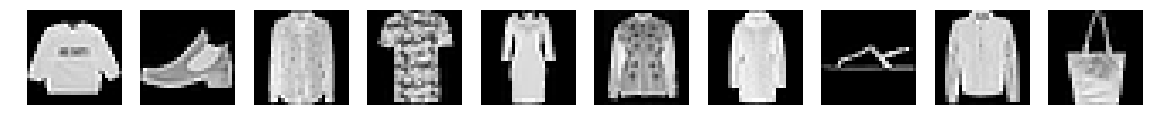

In [5]:
plt.figure(figsize=(20,10))
for i in range(10):
    ax = plt.subplot(1, 10, i+1)
    ax.imshow(train_dataset[i][0].squeeze().asnumpy(), cmap='gray')
    ax.axis('off')

## Network

In [6]:
net = gluon.nn.HybridSequential(prefix='autoencoder_')
with net.name_scope():
    # Encoder 1x28x28 -> 32x1x1
    encoder = gluon.nn.HybridSequential(prefix='encoder_')
    with encoder.name_scope():
        encoder.add(
            gluon.nn.Conv2D(channels=4, kernel_size=3, padding=1, strides=(2,2), activation='relu'),
            gluon.nn.BatchNorm(),
            gluon.nn.Conv2D(channels=8, kernel_size=3, padding=1, strides=(2,2), activation='relu'),
            gluon.nn.BatchNorm(),
            gluon.nn.Conv2D(channels=16, kernel_size=3, padding=1, strides=(2,2), activation='relu'),
            gluon.nn.BatchNorm(),
            gluon.nn.Conv2D(channels=32, kernel_size=3, padding=0, strides=(2,2),activation='relu'),
            gluon.nn.BatchNorm()
        )
    decoder = gluon.nn.HybridSequential(prefix='decoder_')
    # Decoder 32x1x1 -> 1x28x28
    with decoder.name_scope():
        decoder.add(
            gluon.nn.Conv2D(channels=32, kernel_size=3, padding=2, activation='relu'),
            gluon.nn.HybridLambda(lambda F, x: F.UpSampling(x, scale=2, sample_type='nearest')),
            gluon.nn.BatchNorm(),
            gluon.nn.Conv2D(channels=16, kernel_size=3, padding=1, activation='relu'),
            gluon.nn.HybridLambda(lambda F, x: F.UpSampling(x, scale=2, sample_type='nearest')),
            gluon.nn.BatchNorm(),
            gluon.nn.Conv2D(channels=8, kernel_size=3, padding=2, activation='relu'),
            gluon.nn.HybridLambda(lambda F, x: F.UpSampling(x, scale=2, sample_type='nearest')),
            gluon.nn.BatchNorm(),
            gluon.nn.Conv2D(channels=4, kernel_size=3, padding=1, activation='relu'),
            gluon.nn.Conv2D(channels=1, kernel_size=3, padding=1, activation='sigmoid')
        )
    net.add(
        encoder,
        decoder
    )

In [7]:
net.initialize(ctx=ctx)

In [8]:
net.summary(test_dataset_t[0][0].expand_dims(axis=0).as_in_context(ctx))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                              (1, 1, 28, 28)               0
        Activation-1  <Symbol autoencoder_encoder_conv0_relu_fwd>               0
        Activation-2                              (1, 4, 14, 14)               0
            Conv2D-3                              (1, 4, 14, 14)              40
         BatchNorm-4                              (1, 4, 14, 14)              16
        Activation-5  <Symbol autoencoder_encoder_conv1_relu_fwd>               0
        Activation-6                                (1, 8, 7, 7)               0
            Conv2D-7                                (1, 8, 7, 7)             296
         BatchNorm-8                                (1, 8, 7, 7)              32
        Activation-9  <Symbol autoencoder_encoder_conv2_relu_fwd>               0
       Activation-10     

We can see that the original image goes from 28x28 = 784 pixels to a vector of length 32. That is a ~25x information compression rate.
Then the decoder brings back this compressed information to the original shape

In [9]:
l2_loss = gluon.loss.L2Loss()
l1_loss = gluon.loss.L1Loss()

In [10]:
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.001, 'wd':0.001})
net.hybridize(static_shape=True, static_alloc=True)

## Training loop

In [11]:
epochs = 20
for e in range(epochs):
    curr_loss = 0.
    for i, (data, _) in enumerate(train_data):
        data = data.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            # Compute the L2 and L1 losses between the original and the generated image
            l2 = l2_loss(output.flatten(), data.flatten())
            l1 = l1_loss(output.flatten(), data.flatten())
            l =  l2 + l1 
        l.backward()
        trainer.step(data.shape[0])
        
        curr_loss += l.mean()

    print("Epoch [{}], Loss {}".format(e, curr_loss.asscalar()/(i+1)))

Epoch [0], Loss 0.2246280246310764
Epoch [1], Loss 0.14493223337026742
Epoch [2], Loss 0.13147933666522688
Epoch [3], Loss 0.12138325943906084
Epoch [4], Loss 0.11291297684367906
Epoch [5], Loss 0.10611823453741559
Epoch [6], Loss 0.09942417470817892
Epoch [7], Loss 0.09408332955124032
Epoch [8], Loss 0.08883619716024807
Epoch [9], Loss 0.08491455795418502
Epoch [10], Loss 0.0809355994402352
Epoch [11], Loss 0.07784551636785524
Epoch [12], Loss 0.07570812029716296
Epoch [13], Loss 0.07417513366438384
Epoch [14], Loss 0.07218785571236895
Epoch [15], Loss 0.07093704352944584
Epoch [16], Loss 0.0700181406787318
Epoch [17], Loss 0.0689836893326197
Epoch [18], Loss 0.06782063459738708
Epoch [19], Loss 0.06713279088338216


## Testing reconstruction

We plot 10 images and their reconstruction by the autoencoder. The results are pretty good for a ~25x compression rate!

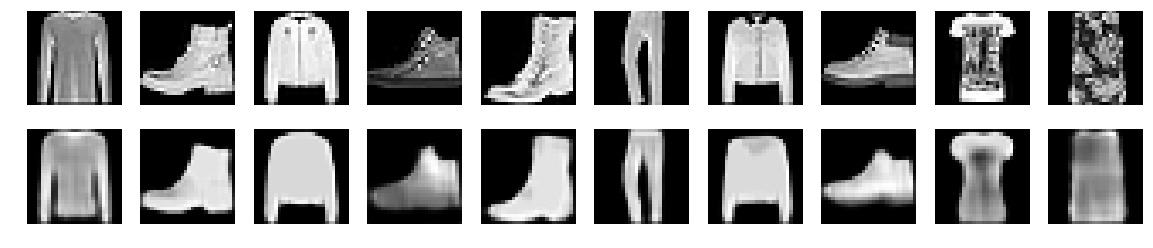

In [12]:
plt.figure(figsize=(20,4))
for i in range(10):
    idx = random.randint(0, len(test_dataset))
    img, _ = test_dataset[idx]
    x, _ = test_dataset_t[idx]

    data = x.as_in_context(ctx).expand_dims(axis=0)
    output = net(data)
    
    ax = plt.subplot(2, 10, i+1)
    ax.imshow(img.squeeze().asnumpy(), cmap='gray')
    ax.axis('off')
    ax = plt.subplot(2, 10, 10+i+1)
    ax.imshow((output[0].asnumpy() * 255.).transpose((1,2,0)).squeeze(), cmap='gray')
    _ = ax.axis('off')

## Manipulating latent space

We now use separately the **encoder** that takes an image to a latent vector and the **decoder** that transform a latent vector into images

We get two images from the testing set

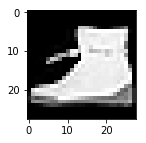

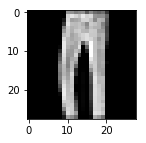

In [26]:
idx = random.randint(0, len(test_dataset))
img1, _ = test_dataset[idx]
x, _ = test_dataset_t[idx]
data1 = x.as_in_context(ctx).expand_dims(axis=0)

idx = random.randint(0, len(test_dataset))
img2, _ = test_dataset[idx]
x, _ = test_dataset_t[idx]
data2 = x.as_in_context(ctx).expand_dims(axis=0)

plt.figure(figsize=(2,2))
plt.imshow(img1.squeeze().asnumpy(), cmap='gray')
plt.show()
plt.figure(figsize=(2,2))
plt.imshow(img2.squeeze().asnumpy(), cmap='gray')

We get the latent representations of the images by passing them through the network

In [27]:
latent1 = encoder(data1)
latent2 = encoder(data2)

We see that the latent vector is made of 32 components

In [28]:
latent1.shape

(1, 32, 1, 1)

We interpolate the two latent representations, vectors of 32 values, to get a new intermediate latent representation, pass it through the decoder and plot the resulting decoded image

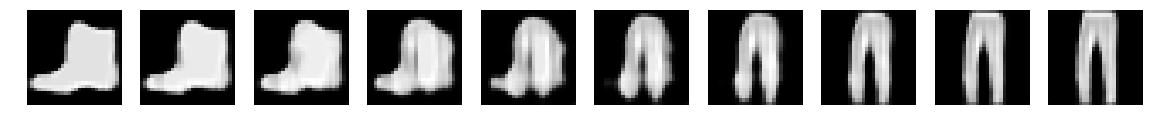

In [29]:
num = 10
plt.figure(figsize=(20, 5))

for i in range(int(num)):
    
        new_latent = latent2*(i+1)/num + latent1*(num-i)/num
        output = decoder(new_latent)
        
        #plot result
        ax = plt.subplot(1, num, i+1)
        ax.imshow((output[0].asnumpy() * 255.).transpose((1,2,0)).squeeze(), cmap='gray')
        _ = ax.axis('off')

We can see that the latent space learnt by the autoencoder is fairly smooth, there is no sudden jump from one shape to another